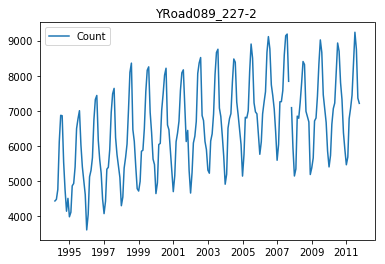

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('YRoad_089.csv')
df.drop(['Annual 24-hr Avg.'], axis=1, inplace=True)
dfLong = pd.melt(df, id_vars=['YEAR'], value_vars=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun','Jul','Aug','Sep', 'Oct','Nov','Dec']).sort_values(by=['YEAR'])
dfLong.columns = ['year', 'month_name', 'count']
dfLong['day'] = 1
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded
dfLong['month'] = coding(dfLong['month_name'], {'Jan':1, 'Feb':2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep': 9, 'Oct':10, 'Nov':11, 'Dec':12})
dfLong = dfLong.sort_values(by=['year', 'month'])
dfLong['date'] = pd.to_datetime(dfLong[['year', 'month', 'day']])
dfLong.set_index('date', inplace=True)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(dfLong.index, dfLong['count'], label='Count')
plt.title('YRoad089_227-2')
ax.legend()

In [2]:
dfLongFill = dfLong.fillna(method='pad')

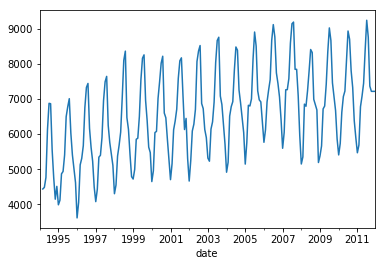

In [3]:
dfLongFill['count'].plot()

In [5]:
dfLongFill.head()

,year,month_name,count,day,month
date,,,,,
1994-01-01,1994,Jan,NaN,1,1
1994-02-01,1994,Feb,NaN,1,2
1994-03-01,1994,Mar,4438.0,1,3
1994-04-01,1994,Apr,4483.0,1,4
1994-05-01,1994,May,4763.0,1,5


In [4]:
time_series = dfLongFill['count']

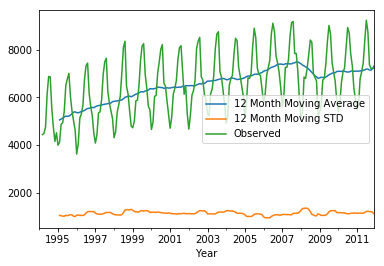

In [34]:
time_series.rolling(12).mean().plot(label='12 Month Moving Average')
time_series.rolling(12).std().plot(label='12 Month Moving STD')
time_series.plot(label='Observed')
plt.legend(loc=5)
plt.xlabel('Year')
plt.savefig('site4ma.png')

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\cfelt\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [7]:
decomp = seasonal_decompose(dfLongFill['count'].dropna())

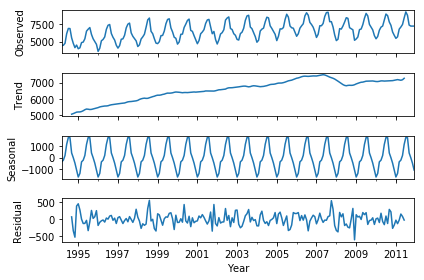

In [35]:
fig = decomp.plot()
plt.xlabel('Year')
fig.savefig('site4decomp.png')

In [31]:
from statsmodels.tsa.stattools import adfuller

In [7]:
def adf_check(time_series):
    result = adfuller(time_series)
    print("Augmented Dicky-Fuller Test")
    labels = ['ADF Test Statistic', 'p-value', '# of lags', 'Num of Observations used']
    
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
        
    if result[1] <= 0.05:
        print("Strong evidence against null hypothesis")
        print('reject null hpothesis')
        print('Data has no unit root and is stationary')
    else:
        print('weak evidence against null hypothesis')
        print('Fail to reject null hypothesis')
        print('Data has a unit root, it is non-stationary')

In [9]:
adf_check(dfLongFill['count'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -1.96462294271
p-value : 0.302296791954
# of lags : 12
Num of Observations used : 201
weak evidence against null hypothesis
Fail to reject null hypothesis
Data has a unit root, it is non-stationary


In [10]:
dfLongFill['first_dif'] = dfLongFill['count'] - dfLongFill['count'].shift(1)

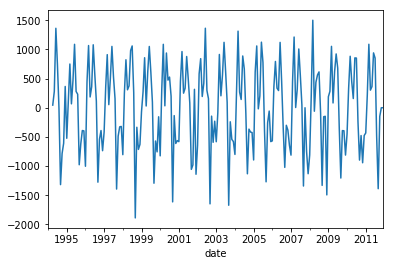

In [11]:
dfLongFill['first_dif'].plot()

In [12]:
adf_check(dfLongFill['first_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -3.20622015275
p-value : 0.0196274437744
# of lags : 15
Num of Observations used : 197
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [13]:
dfLongFill['season_dif'] = dfLongFill['count'] - dfLongFill['count'].shift(12)

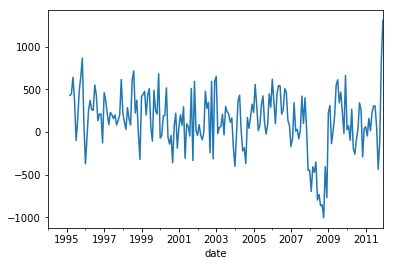

In [14]:
dfLongFill['season_dif'].plot()

In [15]:
adf_check(dfLongFill['season_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -2.86807042346
p-value : 0.0491889544941
# of lags : 13
Num of Observations used : 188
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [16]:
dfLongFill['season_first_dif'] = dfLongFill['first_dif'] - dfLongFill['first_dif'].shift(12)

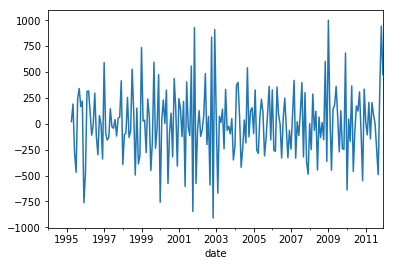

In [17]:
dfLongFill['season_first_dif'].plot()

In [18]:
adf_check(dfLongFill['season_first_dif'].dropna())

Augmented Dicky-Fuller Test
ADF Test Statistic : -5.09413310687
p-value : 1.44048451353e-05
# of lags : 12
Num of Observations used : 188
Strong evidence against null hypothesis
reject null hpothesis
Data has no unit root and is stationary


In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

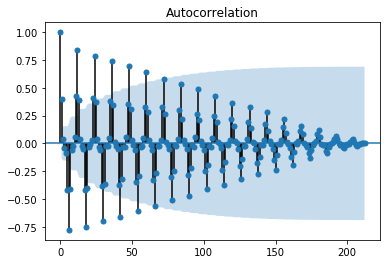

In [20]:
fig_first = plot_acf(dfLongFill['first_dif'].dropna())

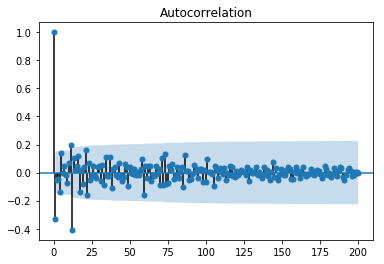

In [21]:
fig_first = plot_acf(dfLongFill['season_first_dif'].dropna())

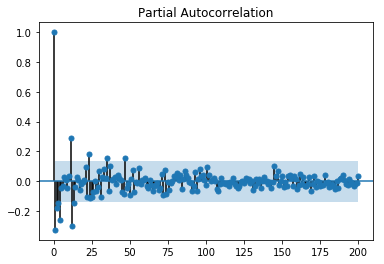

In [22]:
fig_first = plot_pacf(dfLongFill['season_first_dif'].dropna())

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

### Redo Stars** after studying 

C:\Users\christopher\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
model = sm.tsa.statespace.SARIMAX(dfLongFill['count'], order=(0,1,1), seasonal_order=(1,1,1,12)) #**

In [22]:
results = model.fit()   #**

In [23]:
print(results.summary())  #**

                                 Statespace Model Results                                 
Dep. Variable:                              count   No. Observations:                  216
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1410.377
Date:                            Tue, 13 Mar 2018   AIC                           2828.755
Time:                                    19:26:04   BIC                           2842.256
Sample:                                01-01-1994   HQIC                          2834.209
                                     - 12-01-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6546      0.051    -12.796      0.000      -0.755      -0.554
ar.S.L12      -0.0222      0.097   

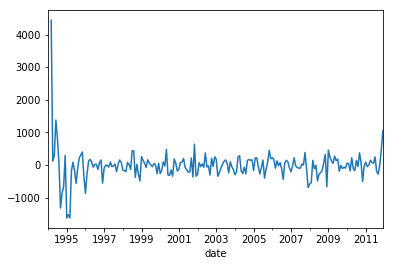

In [24]:
results.resid.plot()  #**

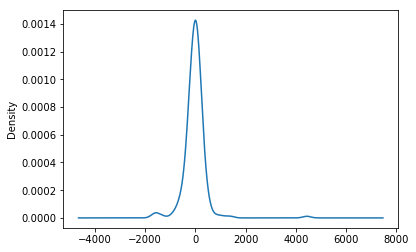

In [25]:
results.resid.plot(kind='kde') #**

In [26]:
from pandas.tseries.offsets import DateOffset 

In [27]:
future_dates = [dfLongFill.index[-1]+DateOffset(months=x) for x in range(1,96)] #add the number that reaches say 2019 #**

In [28]:
future_df = pd.DataFrame(index=future_dates, columns=dfLongFill.columns)  #**

In [29]:
final_df = pd.concat([dfLongFill, future_df])  #**

In [30]:
final_df.head()

,year,month_name,count,day,month
1994-01-01,1994,Jan,NaN,1,1
1994-02-01,1994,Feb,NaN,1,2
1994-03-01,1994,Mar,4438.0,1,3
1994-04-01,1994,Apr,4483.0,1,4
1994-05-01,1994,May,4763.0,1,5


In [31]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 311 entries, 1994-01-01 to 2019-11-01
Data columns (total 5 columns):
year          216 non-null object
month_name    216 non-null object
count         214 non-null float64
day           216 non-null object
month         216 non-null object
dtypes: float64(1), object(4)
memory usage: 14.6+ KB


In [32]:
final_df['forecast']=results.predict(start=204, end=300)

In [33]:
final_df['forecast_trend'] = final_df['forecast'].fillna(dfLongFill['count'])

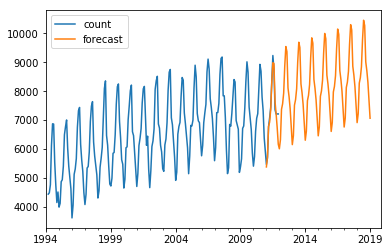

In [34]:
final_df[['count', 'forecast']].plot()

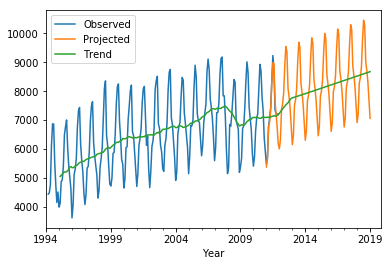

In [35]:
final_df['count'].plot(label='Observed')
final_df['forecast'].plot(label='Projected')
final_df['forecast_trend'].rolling(12).mean().plot(label='Trend')
plt.xlabel('Year')
plt.legend()

plt.savefig('site4project.png')